In [52]:
import pandas as pd
import numpy as np
import statistics as st
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV



In [53]:
wines = pd.read_csv("Data\wines.csv")
print(wines.shape)
wines.head()

(6497, 15)


,Unnamed: 0,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_type,quality_label
0,0,7.0,0.25,0.45,2.3,0.045,40.0,118.0,0.99064,3.16,0.48,11.9,7,white,medium
1,1,7.6,0.14,0.74,1.6,0.040,27.0,103.0,0.99160,3.07,0.40,10.8,7,white,medium
2,2,6.2,0.15,0.27,11.0,0.035,46.0,116.0,0.99602,3.12,0.38,9.1,6,white,medium
3,3,6.7,0.16,0.32,12.5,0.035,18.0,156.0,0.99666,2.88,0.36,9.0,6,white,medium
4,4,6.8,0.27,0.22,17.8,0.034,16.0,116.0,0.99890,3.07,0.53,9.2,5,white,low


In [54]:
wines.drop(columns=["Unnamed: 0"],inplace=True)

In [55]:
# reshuffling the records in the DF is important to make sure the data taken into account by the model will be surely a mix of red and white wines

wines = wines.sample(frac=1, random_state=42).reset_index(drop=True)

In [56]:
# split up our dataset into inputs (X) and our target (y)
#
## ho ottenuto un errore "could not convert string to float: 'white'"
# questo modello lavora solo con dati numerici pertanto la colonna wine_type deve essere o eliminata (se non importante) o trasformata con funzione dummy
# elimino per semplicità, ed eseguo nunovamente gli step precedenti

X = wines.drop(columns=["quality_label", "wine_type"])
y = wines["quality_label"]
y

0       medium
1          low
2          low
3          low
4       medium
         ...  
6492    medium
6493       low
6494       low
6495    medium
6496       low
Name: quality_label, Length: 6497, dtype: object

In [57]:
# Split the dataset into train and test data
# training data is the data that the model will learn from. The testing data is the data I will use to see how well the model performs on unseen data.
# The first two parameters are the input and target data I split up earlier
# This means that 10% of all the data will be used for testing, which leaves 90% of the data as training data for the model to learn from
# ‘random_state’ to 1 ensures that we get the same split each time so we can reproduce our results
# Setting ‘stratify’ to y makes our training split represent the proportion of each value in the y variable. For example, if 25% of patients have diabetes and 75% don’t have diabetes, setting ‘stratify’ to y will ensure that the random split has 25% of patients with diabetes and 75% of patients without diabetes.

X_train, X_test, y_train, y_test= train_test_split(X,y,test_size=0.1,random_state=1,stratify=y)

In [58]:
X_train.shape

(5847, 12)

In [59]:
y_test.shape

(650,)

In [60]:
# Build the model
# from sklearn.neighbors import KNeighborsClassifier
# Create KNN classifier
# n_neighbors = 3  means that if at least 2 out of the 3 nearest points to a new data point are of "low quality" then the new data point will be labeled as "low quality"
# train the model - use the ‘fit’ function and pass it in the training data as parameters to fit the model to the training data.

knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)



KNeighborsClassifier(n_neighbors=3)

In [61]:
# Once the model is trained, I can use the ‘predict’ function to make predictions on our test data.
# show just the first 20 predictions of our test set.
knn.predict(X_test)[0:20]

array(['low', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium',
       'medium', 'low', 'low', 'medium', 'medium', 'medium', 'medium',
       'medium', 'medium', 'low', 'medium', 'medium', 'low'], dtype=object)

In [62]:
# Accuracy of model on the full test set. 
# use the ‘score’ function and pass in our test input and target data to see how well our model predictions match up to the actual results.
knn.score(X_test, y_test)

0.7276923076923076

In [63]:
# Cross-validation is when the dataset is randomly split up into ‘k’ groups. One of the groups is used as the test set and the rest are used as the training set. The model is trained on the training set and scored on the test set. Then the process is repeated until each unique group as been used as the test set
# The train-test-split method we used in earlier is called ‘holdout’. Cross-validation is better than using the holdout method because the holdout method score is dependent on how the data is split into train and test sets. Cross-validation gives the model an opportunity to test on multiple splits so we can get a better idea on how the model will perform on unseen data
# create a new KNN model
knn_cv = KNeighborsClassifier(n_neighbors=3)

In [64]:
# train model with cv of 5 
cv_scores = cross_val_score(knn_cv, X, y, cv=5, scoring="accuracy")
#print each cv score (accuracy) and average them
cv_scores


array([0.72076923, 0.74230769, 0.72517321, 0.72979215, 0.74210931])

In [65]:
print("cv_scores mean:{}".format(np.mean(cv_scores)))

cv_scores mean:0.7320303191804346


In [66]:
# Hypertuning model parameters using GridSearchCV: Hypertuning parameters is when you go through a process to find the optimal parameters for your model to improve accuracy.
# GridSearchCV works by training our model multiple times on a range of parameters that we specify. That way, we can test our model with each parameter and figure out the optimal values to get the best accuracy results.
# For our model, we will specify a range of values for ‘n_neighbors’ in order to see which value works best for our model. To do this, we will create a dictionary, setting ‘n_neighbors’ as the key and using numpy to create an array of values from 1 to 24.
# Our new model using grid search will take in a new k-NN classifier, our param_grid and a cross-validation value of 5 in order to find the optimal value for ‘n_neighbors’.

In [67]:
# create new a knn model
knn2 = KNeighborsClassifier()

In [68]:
#create a dictionary of all values I want to test for n_neighbors
param_grid = {"n_neighbors": np.arange(1, 25)}


In [69]:
#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn2, param_grid, cv=5)

In [70]:
knn_gscv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])})

In [71]:
#check top performing n_neighbors value
knn_gscv.best_params_

{'n_neighbors': 1}

In [72]:
#check mean score for the top performing value of n_neighbors
knn_gscv.best_score_

0.7761254048679198

In [73]:
# Instead of GridSearchCV I can use for loop
k_range= range(1,41)
k_scores=[]

for k in k_range:
    knn_cv = KNeighborsClassifier(n_neighbors= k)
    scores= cross_val_score(knn_cv, X, y, cv=5, scoring="accuracy")
    k_scores.append(scores.mean())


In [74]:
k_scores

[0.7855924675786106,
 0.7191006099366376,
 0.7320303191804346,
 0.7189451057026115,
 0.7140206075679516,
 0.704630781074199,
 0.7061698347841536,
 0.7080183573162788,
 0.7067884171255996,
 0.7057085331912122,
 0.7006288861254218,
 0.6983195357375497,
 0.700937170604607,
 0.6995535026943803,
 0.6967822585420739,
 0.6975525552199916,
 0.6943189435660567,
 0.6938572866702197,
 0.6893933795227098,
 0.6881626102919406,
 0.6850850950435247,
 0.6863156274056966,
 0.6855453307277788,
 0.6826211878960147,
 0.680004737371943,
 0.6807734944039794,
 0.6783132587197253,
 0.6789281695979155,
 0.678313377154024,
 0.6780046189376444,
 0.676772783798188,
 0.6752336116539349,
 0.671231124533665,
 0.6756955054183693,
 0.675233848522532,
 0.6755423698703144,
 0.676003908331853,
 0.6736957422869663,
 0.6730794101971932,
 0.6720021318173743]

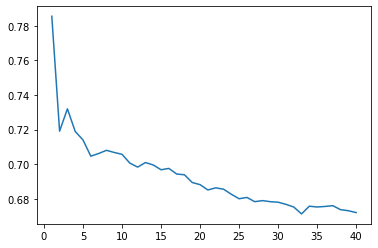

In [75]:
sns.lineplot(x=k_range, y= k_scores);

In [76]:
# As we decrease the value of K to 1, our predictions become less stable
# when the value of k is really low it means that there is a high VARIANCE low bias -> overfitting
# when the value of k is really high it means that there is a low VARIANCE high bias -> underfitting
# we should pick a value of k that is in between considering that the higher is the value of k the simpler is our model

In [77]:
#
#
# I will try to change the data (more categories quality label) to see if k varies 
#
#

In [78]:
red_wine = pd.read_csv("Data\winequality-red.csv", sep=";")
white_wine = pd.read_csv("Data\winequality-white.csv", sep=";")

In [79]:
red_wine['quality_label'] = red_wine['quality'].apply(lambda value: "low" if value <= 3 else 'low-medium' if value <=5 else "medium" if value <=6 else 'medium-high' if value <=7 else 'high')
white_wine['quality_label'] = white_wine['quality'].apply(lambda value: "low" if value <= 3 else 'low-medium' if value <=5 else "medium" if value <=6 else 'medium-high' if value <=7 else 'high')


In [80]:
wines = pd.concat([white_wine,red_wine])

In [81]:
wines = wines.sample(frac=1, random_state=42).reset_index(drop=True)

In [82]:
X = wines.drop(columns=["quality_label"])
y = wines["quality_label"]

In [83]:
X_train, X_test, y_train, y_test= train_test_split(X,y,test_size=0.1,random_state=1,stratify=y)

In [84]:
from sklearn.neighbors import KNeighborsClassifier
kn = KNeighborsClassifier(n_neighbors = 3)
kn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [85]:
kn.predict(X_test)[0:20]

array(['medium', 'medium-high', 'low-medium', 'medium', 'low-medium',
       'medium', 'medium', 'medium', 'medium', 'medium', 'medium-high',
       'low-medium', 'low-medium', 'medium', 'low-medium', 'medium',
       'medium', 'medium', 'low-medium', 'low-medium'], dtype=object)

In [86]:
kn.score(X_test, y_test)

0.6338461538461538

In [87]:
cv_scores = cross_val_score(kn, X, y, cv=5, scoring="accuracy")
cv_scores

array([0.59769231, 0.60538462, 0.61046959, 0.58660508, 0.57428791])

In [88]:
k_range= range(1,20)
k_scores1 =[]

for k in k_range:
    kn = KNeighborsClassifier(n_neighbors= k)
    scores= cross_val_score(kn, X, y, cv=5, scoring="accuracy")
    k_scores1.append(scores.mean())

In [89]:
k_scores1

[0.6857004796589091,
 0.617667318055309,
 0.5948879019364007,
 0.5854997335228281,
 0.5787265944217446,
 0.5658012672469948,
 0.5628727423461835,
 0.5577946349262747,
 0.557488126961568,
 0.5585636288269082,
 0.5567164090720673,
 0.5570257594599396,
 0.5493282406584947,
 0.5491761710191272,
 0.5419401906792207,
 0.5424029134837449,
 0.5413263457097176,
 0.540557351809084,
 0.5374780600461893]

In [90]:
# optimal level of k is still 1

In [91]:
# new trial with weights that weights the point in each neighborhood either uniformly or by the inverse of their distance(gives a greater influcence to closer neighbors)

In [92]:
k_scores1 = []
for k in k_range:
    kn = KNeighborsClassifier(n_neighbors= k, weights="distance", algorithm = "brute")
    scores= cross_val_score(kn, X, y, cv=20, scoring="accuracy")
    k_scores1.append(scores.mean())

In [93]:
len(k_scores1)

19

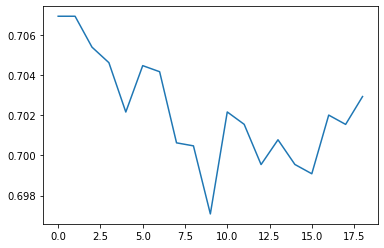

In [94]:
sns.lineplot(x=list(range(len(k_scores1))), y= k_scores1);